<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in New York City</font></h1>

Let's import all the libraries we will need first

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
from geopy.geocoders import Nominatim
import folium
from wordcloud import WordCloud, STOPWORDS
import numpy as np # library to handle data in a vectorized manner
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


The Data file i directly from open source data from Sanfransisco Police Department 

In [120]:
df=pd.read_csv('2016.csv')

In [3]:
df.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168
2,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,01/05/2016 12:00:00 AM,23:50,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,01/01/2016 12:00:00 AM,00:30,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000


In [9]:
df.shape

(150500, 13)

In [11]:
df.dtypes

IncidntNum      int64
Category       object
Descript       object
DayOfWeek      object
Date           object
Time           object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
Location       object
PdId            int64
dtype: object

Let's Check the Location Column exact type 

In [12]:
type(df.Location[0])

str

We will be using it in the reverse geo search, so let's build a function and transform it to tuple of float

In [13]:
def str_to_tuple(x):
    y=x.split(',')
    f=float(y[0].split('(')[1])
    k=float(y[1].split(' ')[1].split(')')[0])
    
    return f,k

In [14]:
df.Location=df.Location.apply(lambda x: str_to_tuple(x))
type(df.Location[0])

tuple

#### Let's Rename X and Y to Latitude and Longitude Respectively

In [15]:
df.rename(columns={'X':'Longitude','Y':'Latitude'},inplace=True)
df.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,Longitude,Latitude,Location,PdId
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168
2,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,01/05/2016 12:00:00 AM,23:50,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,01/01/2016 12:00:00 AM,00:30,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000


#### We won't be needing the 'Resolution','PdId','Descript','IncidntNum','Date' Anymore Column Anymore So let's Drop them 

In [16]:
df.drop(columns=['Resolution','PdId','Descript','IncidntNum','Date'],inplace=True)
df.head()

,Category,DayOfWeek,Time,PdDistrict,Address,Longitude,Latitude,Location
0,WEAPON LAWS,Friday,11:00,SOUTHERN,800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)"
1,WEAPON LAWS,Friday,11:00,SOUTHERN,800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)"
2,WARRANTS,Monday,14:59,BAYVIEW,KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)"
3,NON-CRIMINAL,Tuesday,23:50,TENDERLOIN,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)"
4,NON-CRIMINAL,Friday,00:30,MISSION,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)"


In [17]:
# San Francisco latitude and longitude values
latitude = 37.77
longitude = -122.42

#### Let's Check the PdDistrict(s) in the dataframe

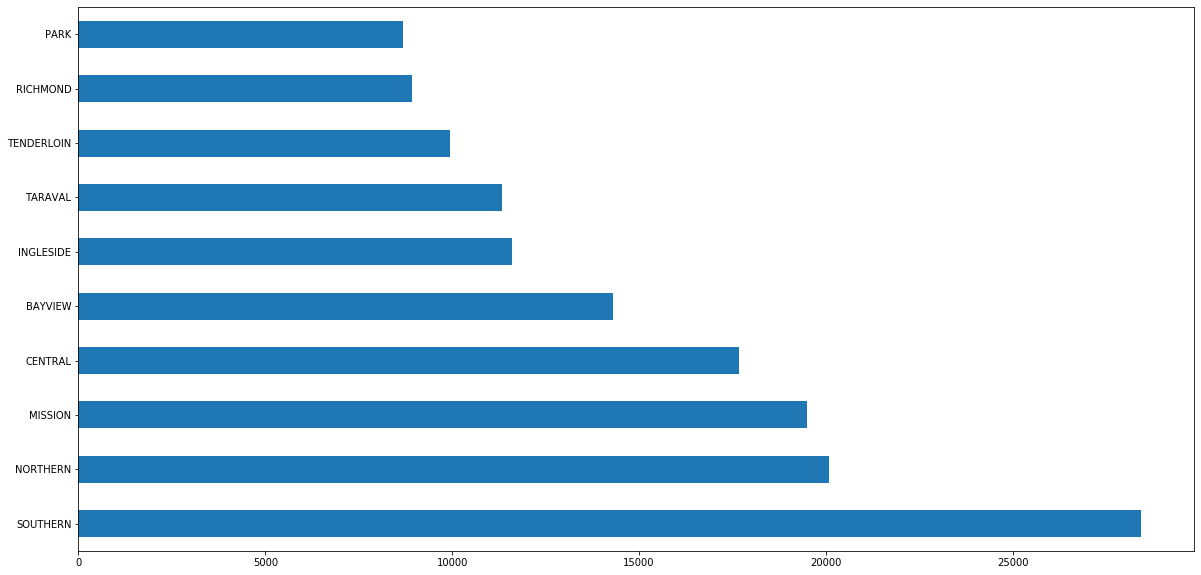

In [18]:
plt.figure(figsize=(20,10))
df.PdDistrict.value_counts().plot(kind='barh')

In [121]:
df22=df['PdDistrict'].value_counts().to_frame()
df22.rename(columns={'PdDistrict':'Count'},inplace=True)
df22.reset_index(inplace=True)
df22.rename(columns={'index':'District'},inplace=True)

## So, Let's Visualize them also on map 

In [116]:
!wget --quiet https://cocl.us/sanfran_geojson -O sanfran_geojson.json
san_geo = r'sanfran_geojson.json'


In [128]:
san_map = folium.Map(location=[37.7749,-122.4194], zoom_start=12)
san_map.choropleth(
    geo_data=san_geo,
    data=df22,
    columns=['District', 'Count'],
    key_on='feature.properties.DISTRICT',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Crime Rate in San Francisco'
)
san_map

In [20]:
df.PdDistrict.value_counts().to_frame()

,PdDistrict
SOUTHERN,28445
NORTHERN,20100
MISSION,19503
CENTRAL,17666
BAYVIEW,14303
INGLESIDE,11594
TARAVAL,11325
TENDERLOIN,9942
RICHMOND,8922
PARK,8699


### As we saw the Southern District has the most crime rate, so let's analyise it

In [22]:
SOUTHERN=df.query('PdDistrict == "SOUTHERN" ').copy()
SOUTHERN.head()

,Category,DayOfWeek,Time,PdDistrict,Address,Longitude,Latitude,Location
0,WEAPON LAWS,Friday,11:00,SOUTHERN,800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)"
1,WEAPON LAWS,Friday,11:00,SOUTHERN,800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)"
6,OTHER OFFENSES,Saturday,00:04,SOUTHERN,MARY ST / HOWARD ST,-122.405721,37.780879,"(37.7808789360214, -122.405721454567)"
8,WARRANTS,Saturday,12:21,SOUTHERN,4TH ST / BERRY ST,-122.393357,37.775788,"(37.7757876218293, -122.393357241451)"
15,STOLEN PROPERTY,Saturday,11:54,SOUTHERN,900 Block of MARKET ST,-122.408595,37.783707,"(37.7837069301545, -122.408595110869)"


In [23]:
SOUTHERN.shape

(28445, 8)

### Let's Use the World Cloud to see which of the crimes happens the most in the Southern PdDistrict

In [24]:
cat_wc=SOUTHERN.Category.copy()
cat_wc.apply(lambda x: x.replace(" ","_"))
cat_wc=cat_wc.to_string(header=False,index=False)
# instantiate a word cloud object
south_wc = WordCloud(
    background_color='black'
    , max_words=SOUTHERN.shape[0]
    ,width=2000,height=1000
)

# generate the word cloud
south_wc.generate(cat_wc)

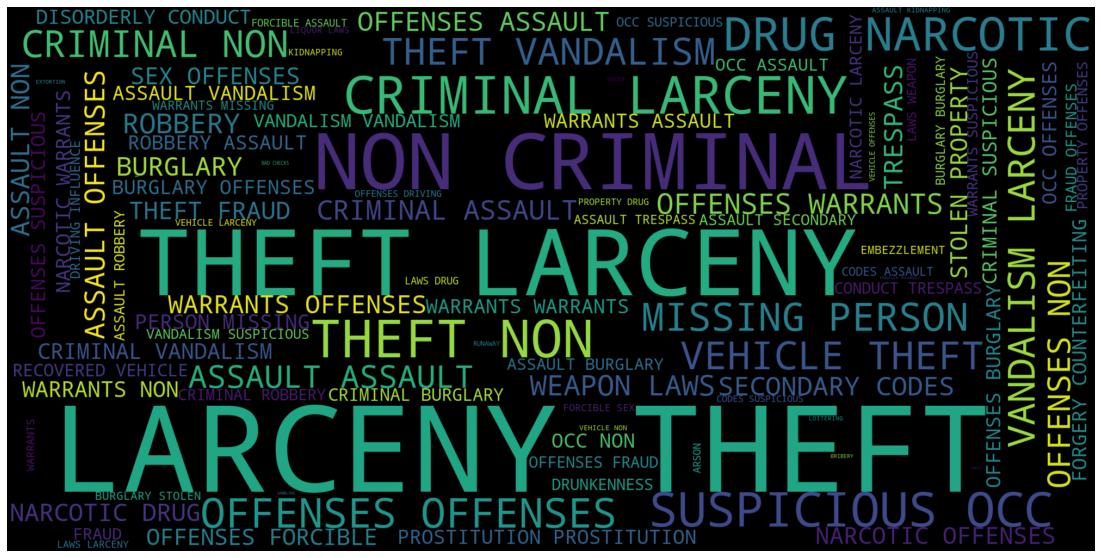

In [25]:
plt.figure(figsize=(20,10))
plt.imshow(south_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## So let's check if the Day of the week has anything to do with the crime rate in the SOUTHERN pd District

<Figure size 720x720 with 0 Axes>

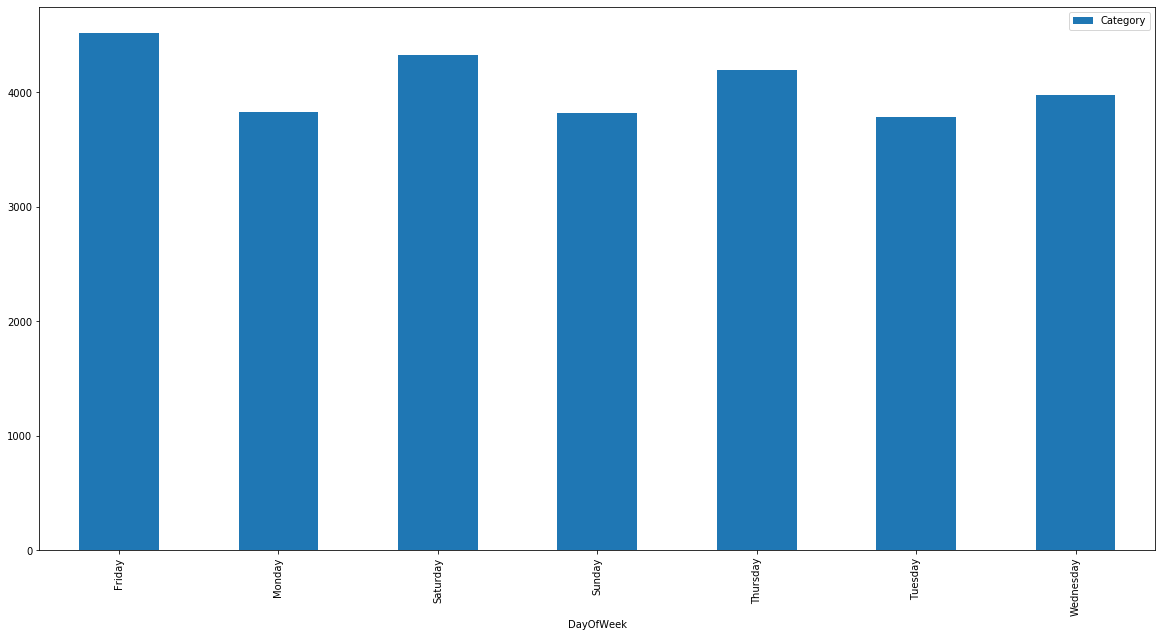

In [213]:
SOUTHERN.groupby('DayOfWeek').count().iloc[:,[0]].plot(kind='bar',figsize=(20,10))

#### Considering the plot above , all days are so close to each other 

.

## As we are seeing the Southern District has alot of Theft Criminal Activity in it
#### Let's Also check by numbers

In [26]:
south_crimes=SOUTHERN.Category.value_counts().to_frame().copy()
Theft=south_crimes.iloc[0][0]/SOUTHERN.shape[0]
south_crimes.head(5)

,Category
LARCENY/THEFT,9203
NON-CRIMINAL,3402
OTHER OFFENSES,3336
ASSAULT,2352
VANDALISM,1439


In [27]:
Theft

0.32353664967481105

As the We Illsutrated in the World Cloud, The Larceny/Theft Activity is the highest With proportion 0.32

Let's Check the location to find if there's any remarkable thing we can know

In [30]:
SOUTHERN.Location.value_counts().to_frame().head(10)

,Location
"(37.775420706711, -122.403404791479)",3536
"(37.7841893501425, -122.407633520742)",624
"(37.7850629421661, -122.406520987144)",513
"(37.7799444052046, -122.414317857881)",299
"(37.7835699386918, -122.408421116922)",294
"(37.7835100715421, -122.405395493939)",286
"(37.8096707013239, -122.365565425353)",244
"(37.7827317884887, -122.406481972743)",238
"(37.7852071918419, -122.406690592261)",236
"(37.7852686309087, -122.403070000847)",234


And as i thought, there's a multiple incedents happend at the same exact location more that 3500 times through the course of one year !

In [103]:
southernloc=pd.DataFrame({'count' : SOUTHERN.groupby(["Longitude","Latitude","Address","Location"]).size()}).reset_index()
southernloc.sort_values('count',ascending=False,inplace=True)
southernloc.reset_index(drop=True,inplace=True)
southernloc.head(10)

,Longitude,Latitude,Address,Location,count
0,-122.403405,37.775421,800 Block of BRYANT ST,"(37.775420706711, -122.403404791479)",3536
1,-122.407634,37.784189,800 Block of MARKET ST,"(37.7841893501425, -122.407633520742)",624
2,-122.406521,37.785063,800 Block of MARKET ST,"(37.7850629421661, -122.406520987144)",513
3,-122.414318,37.779944,0 Block of UNITEDNATIONS PZ,"(37.7799444052046, -122.414317857881)",299
4,-122.408421,37.783570,900 Block of MARKET ST,"(37.7835699386918, -122.408421116922)",294
5,-122.405395,37.783510,800 Block of MISSION ST,"(37.7835100715421, -122.405395493939)",286
6,-122.365565,37.809671,200 Block of INTERSTATE80 HY,"(37.8096707013239, -122.365565425353)",244
7,-122.406691,37.785207,800 Block of MARKET ST,"(37.7852071918419, -122.406690592261)",236
8,-122.403070,37.785269,700 Block of MISSION ST,"(37.7852686309087, -122.403070000847)",234
9,-122.413046,37.773862,0 Block of DORE ST,"(37.7738617771611, -122.413045971966)",195


So Let's Analyise the top 10 Only 

## We should get the Neighborhood of each location first ONLY THE TOP TEN

In [104]:
southernloc=southernloc.head(10)

In [ ]:
geolocator=Nominatim()

In [106]:
southernloc['Neighborhood']=southernloc['Location'].apply(lambda x :geolocator.reverse(x)[0].split(',')[2].strip())
southernloc

,Longitude,Latitude,Address,Location,count,Neighborhood
0,-122.403405,37.775421,800 Block of BRYANT ST,"(37.775420706711, -122.403404791479)",3536,West SoMa
1,-122.407634,37.784189,800 Block of MARKET ST,"(37.7841893501425, -122.407633520742)",624,Union Square
2,-122.406521,37.785063,800 Block of MARKET ST,"(37.7850629421661, -122.406520987144)",513,Union Square
3,-122.414318,37.779944,0 Block of UNITEDNATIONS PZ,"(37.7799444052046, -122.414317857881)",299,San Francisco
4,-122.408421,37.783570,900 Block of MARKET ST,"(37.7835699386918, -122.408421116922)",294,Union Square
5,-122.405395,37.783510,800 Block of MISSION ST,"(37.7835100715421, -122.405395493939)",286,South of Market
6,-122.365565,37.809671,200 Block of INTERSTATE80 HY,"(37.8096707013239, -122.365565425353)",244,San Francisco
7,-122.406691,37.785207,800 Block of MARKET ST,"(37.7852071918419, -122.406690592261)",236,Union Square
8,-122.403070,37.785269,700 Block of MISSION ST,"(37.7852686309087, -122.403070000847)",234,Union Square
9,-122.413046,37.773862,0 Block of DORE ST,"(37.7738617771611, -122.413045971966)",195,Dore Street


## Some of them is happening at the same neighborhood but different Location, so let's use the Foursquare Api to get the neareast venue of Each 

Due to Security Concerns i missed my Client id and secret up , you can you yours to search tho

In [ ]:
CLIENT_ID = 'OZTKQGQEGVWIHNXR4......BOBM4JY5HBHGFLRX' # your Foursquare ID
CLIENT_SECRET = '5I2H2WGI4F............RSN3YVA41WWMSCCRJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

### Function for Returning The Nearest Venue According to the Foursuare API

In [61]:

def get_info(lat,lng):
    # create the API request URL

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                100, 
                5)

    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    venues_list=[]      
    # return only relevant information for each nearby venue
    venues_list.append([(
                lat, 
                lng, 
                v['venue']['name'],  
                v['venue']['categories'][0]['name'],
                v['venue']['location']['distance'],
                1-v['venue']['location']['distance']/100) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Latitude', 
                      'Longitude', 
                      'Venue', 
                      'Venue Category',
                      'Distance From Location',
                       'Accuracy'] 
    nearby_venues.sort_values('Accuracy',ascending=False,inplace=True,)
    return nearby_venues.iloc[[0],:]

In [100]:
df=pd.DataFrame()

In [107]:
for i,lat,lng in zip(range(southernloc.shape[0]),southernloc.Latitude,southernloc.Longitude):
    df=pd.concat([df,get_info(lat,lng)])

In [109]:
southernloc=pd.merge(southernloc,df,on=['Latitude','Longitude'],how='left')

In [114]:
southernloc.drop(0,inplace=True)

In [115]:
southernloc

,Longitude,Latitude,Address,Location,count,Neighborhood,Venue,Venue Category,Distance From Location,Accuracy
1,-122.403405,37.775421,800 Block of BRYANT ST,"(37.775420706711, -122.403404791479)",3536,West SoMa,Golden Burma,Burmese Restaurant,26,0.74
2,-122.407634,37.784189,800 Block of MARKET ST,"(37.7841893501425, -122.407633520742)",624,Union Square,Powell Street Cable Car Turnaround,Cable Car,51,0.49
3,-122.406521,37.785063,800 Block of MARKET ST,"(37.7850629421661, -122.406520987144)",513,Union Square,The Glass Room,Art Gallery,24,0.76
4,-122.414318,37.779944,0 Block of UNITEDNATIONS PZ,"(37.7799444052046, -122.414317857881)",299,San Francisco,Heart of The City Farmers Market,Farmers Market,6,0.94
5,-122.408421,37.783570,900 Block of MARKET ST,"(37.7835699386918, -122.408421116922)",294,Union Square,Mikkeller Bar SF,Gastropub,70,0.30
6,-122.405395,37.783510,800 Block of MISSION ST,"(37.7835100715421, -122.405395493939)",286,South of Market,Bloomingdale's,Department Store,46,0.54
7,-122.365565,37.809671,200 Block of INTERSTATE80 HY,"(37.8096707013239, -122.365565425353)",244,San Francisco,Yerba Buena Island Tunnel,Tunnel,2,0.98
8,-122.406691,37.785207,800 Block of MARKET ST,"(37.7852071918419, -122.406690592261)",236,Union Square,The Glass Room,Art Gallery,8,0.92
9,-122.403070,37.785269,700 Block of MISSION ST,"(37.7852686309087, -122.403070000847)",234,Union Square,Yerba Buena Center for the Arts,Art Museum,59,0.41
10,-122.413046,37.773862,0 Block of DORE ST,"(37.7738617771611, -122.413045971966)",195,Dore Street,Tank 18,Wine Bar,79,0.21


# Now we have the Neighborhood and the nearest Venue to the incedents with Distance in meters

Now Let's get the number of categories for each row 

In [ ]:
south_onehot=pd.get_dummies(SOUTHERN[['Category']])
south_onehot

In [130]:
SOUTHERN.join(south_onehot)
south_onehot.shape

(28445, 38)

In [131]:
southern=pd.concat([SOUTHERN,south_onehot],axis=1)

In [132]:
southern=southern.iloc[:,7:]

In [133]:
southern=southern.groupby('Location').sum()

In [134]:
final_south=pd.merge(southernloc,southern,on='Location',how='left')

In [135]:
final_south

,Longitude,Latitude,Address,Location,count,Neighborhood,Venue,Venue Category,Distance From Location,Accuracy,Category_ARSON,Category_ASSAULT,Category_BAD CHECKS,Category_BRIBERY,Category_BURGLARY,Category_DISORDERLY CONDUCT,Category_DRIVING UNDER THE INFLUENCE,Category_DRUG/NARCOTIC,Category_DRUNKENNESS,Category_EMBEZZLEMENT,Category_EXTORTION,Category_FAMILY OFFENSES,Category_FORGERY/COUNTERFEITING,Category_FRAUD,Category_GAMBLING,Category_KIDNAPPING,Category_LARCENY/THEFT,Category_LIQUOR LAWS,Category_LOITERING,Category_MISSING PERSON,Category_NON-CRIMINAL,Category_OTHER OFFENSES,Category_PROSTITUTION,Category_RECOVERED VEHICLE,Category_ROBBERY,Category_RUNAWAY,Category_SECONDARY CODES,"Category_SEX OFFENSES, FORCIBLE","Category_SEX OFFENSES, NON FORCIBLE",Category_STOLEN PROPERTY,Category_SUICIDE,Category_SUSPICIOUS OCC,Category_TREA,Category_TRESPASS,Category_VANDALISM,Category_VEHICLE THEFT,Category_WARRANTS,Category_WEAPON LAWS
0,-122.403405,37.775421,800 Block of BRYANT ST,"(37.775420706711, -122.403404791479)",3536,West SoMa,Golden Burma,Burmese Restaurant,26,0.74,3.0,196.0,1.0,3.0,63.0,10.0,8.0,57.0,10.0,2.0,1.0,2.0,13.0,68.0,0.0,1.0,1350.0,4.0,1.0,91.0,484.0,471.0,1.0,5.0,30.0,7.0,51.0,61.0,7.0,15.0,3.0,108.0,0.0,32.0,156.0,9.0,185.0,27.0
1,-122.407634,37.784189,800 Block of MARKET ST,"(37.7841893501425, -122.407633520742)",624,Union Square,Powell Street Cable Car Turnaround,Cable Car,51,0.49,2.0,54.0,0.0,0.0,24.0,0.0,0.0,4.0,1.0,9.0,0.0,0.0,2.0,25.0,0.0,1.0,279.0,1.0,0.0,7.0,66.0,30.0,0.0,0.0,25.0,1.0,14.0,1.0,0.0,1.0,0.0,19.0,0.0,15.0,6.0,0.0,31.0,6.0
2,-122.406521,37.785063,800 Block of MARKET ST,"(37.7850629421661, -122.406520987144)",513,Union Square,The Glass Room,Art Gallery,24,0.76,1.0,35.0,0.0,0.0,21.0,5.0,0.0,6.0,2.0,4.0,0.0,0.0,4.0,8.0,1.0,1.0,208.0,1.0,1.0,11.0,39.0,42.0,0.0,0.0,22.0,0.0,8.0,0.0,0.0,2.0,0.0,8.0,0.0,18.0,5.0,0.0,55.0,5.0
3,-122.414318,37.779944,0 Block of UNITEDNATIONS PZ,"(37.7799444052046, -122.414317857881)",299,San Francisco,Heart of The City Farmers Market,Farmers Market,6,0.94,0.0,21.0,0.0,0.0,0.0,0.0,0.0,26.0,2.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,21.0,0.0,0.0,1.0,36.0,62.0,1.0,0.0,8.0,0.0,1.0,0.0,0.0,11.0,0.0,7.0,0.0,0.0,3.0,0.0,86.0,8.0
4,-122.408421,37.783570,900 Block of MARKET ST,"(37.7835699386918, -122.408421116922)",294,Union Square,Mikkeller Bar SF,Gastropub,70,0.30,0.0,11.0,0.0,0.0,10.0,0.0,0.0,8.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,158.0,1.0,0.0,2.0,8.0,22.0,0.0,0.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,0.0,4.0,5.0,2.0,38.0,1.0
5,-122.405395,37.783510,800 Block of MISSION ST,"(37.7835100715421, -122.405395493939)",286,South of Market,Bloomingdale's,Department Store,46,0.54,0.0,5.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,188.0,0.0,0.0,1.0,6.0,11.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,1.0,21.0,24.0,5.0,0.0
6,-122.365565,37.809671,200 Block of INTERSTATE80 HY,"(37.8096707013239, -122.365565425353)",244,San Francisco,Yerba Buena Island Tunnel,Tunnel,2,0.98,1.0,22.0,0.0,0.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,64.0,0.0,0.0,28.0,33.0,19.0,0.0,6.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,12.0,0.0,7.0,19.0,6.0,2.0,2.0
7,-122.406691,37.785207,800 Block of MARKET ST,"(37.7852071918419, -122.406690592261)",236,Union Square,The Glass Room,Art Gallery,8,0.92,0.0,16.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,154.0,0.0,1.0,2.0,13.0,15.0,0.0,0.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,6.0,0.0,5.0,1.0
8,-122.403070,37.785269,700 Block of MISSION ST,"(37.7852686309087, -122.403070000847)",234,Union Square,Yerba Buena Center for the Arts,Art Museum,59,0.41,0.0,20.0,0.0,0.0,2.0,0.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,9.0,0.0,0.0,104.0,0.0,0.0,4.0,15.0,20.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,2.0,0.0,5.0,0.0,4.0,5.0,0.0,25.0,1.0
9,-122.413046,37.773862,0 Block of DORE ST,"(37.7738617771611, -122.413045971966)",195,Dore Street,Tank 18,Wine Bar,79,0.21,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,133.0,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.

In [192]:
for_cat=pd.DataFrame()

In [193]:
for_cat[['Neighborhood','Venue','Venue Category']]=final_south[['Neighborhood','Venue','Venue Category']]
for_cat['Most Crime Type']=final_south.iloc[:,10:].idxmax(axis=1)
for_cat['Most Crime Type']=for_cat['Most Crime Type'].apply(lambda x: x.replace("Category_"," "))
for_cat['Count']=final_south.iloc[:,10:].max(axis=1)
for_cat

,Neighborhood,Venue,Venue Category,Most Crime Type,Count
0,West SoMa,Golden Burma,Burmese Restaurant,LARCENY/THEFT,1350.0
1,Union Square,Powell Street Cable Car Turnaround,Cable Car,LARCENY/THEFT,279.0
2,Union Square,The Glass Room,Art Gallery,LARCENY/THEFT,208.0
3,San Francisco,Heart of The City Farmers Market,Farmers Market,WARRANTS,86.0
4,Union Square,Mikkeller Bar SF,Gastropub,LARCENY/THEFT,158.0
5,South of Market,Bloomingdale's,Department Store,LARCENY/THEFT,188.0
6,San Francisco,Yerba Buena Island Tunnel,Tunnel,LARCENY/THEFT,64.0
7,Union Square,The Glass Room,Art Gallery,LARCENY/THEFT,154.0
8,Union Square,Yerba Buena Center for the Arts,Art Museum,LARCENY/THEFT,104.0
9,Dore Street,Tank 18,Wine Bar,MISSING PERSON,133.0


## Finally Let's Know about the day that has the most crime in each location

In [297]:
for_cat['Highest Day']=""
for_cat['Highest_Day_Count']=0
for_cat

for i,loc,cat in zip(range(for_cat.shape[0]),final_south.Location,for_cat['Most Crime Type']):
    cat=cat.strip()
    for_cat.iloc[i,5]=SOUTHERN.query('Location == @loc and Category == @cat ').groupby('DayOfWeek').count().max(axis=1).idxmax()
    for_cat.iloc[i,6]=SOUTHERN.query('Location == @loc and Category == @cat ').groupby('DayOfWeek').count().max(axis=1).max()
    


for_cat['Percentage']=((for_cat['Highest_Day_Count']/for_cat['Count'])*100)
for_cat

,Neighborhood,Venue,Venue Category,Most Crime Type,Count,Highest Day,Highest_Day_Count,Percentage
0,West SoMa,Golden Burma,Burmese Restaurant,LARCENY/THEFT,1350.0,Friday,215,15.925926
1,Union Square,Powell Street Cable Car Turnaround,Cable Car,LARCENY/THEFT,279.0,Monday,50,17.921147
2,Union Square,The Glass Room,Art Gallery,LARCENY/THEFT,208.0,Tuesday,34,16.346154
3,San Francisco,Heart of The City Farmers Market,Farmers Market,WARRANTS,86.0,Thursday,22,25.581395
4,Union Square,Mikkeller Bar SF,Gastropub,LARCENY/THEFT,158.0,Friday,26,16.455696
5,South of Market,Bloomingdale's,Department Store,LARCENY/THEFT,188.0,Saturday,38,20.212766
6,San Francisco,Yerba Buena Island Tunnel,Tunnel,LARCENY/THEFT,64.0,Saturday,16,25.000000
7,Union Square,The Glass Room,Art Gallery,LARCENY/THEFT,154.0,Wednesday,30,19.480519
8,Union Square,Yerba Buena Center for the Arts,Art Museum,LARCENY/THEFT,104.0,Wednesday,22,21.153846
9,Dore Street,Tank 18,Wine Bar,MISSING PERSON,133.0,Monday,26,19.548872
